In [1]:
from utils import imshow, print_pretty, save_dict
from coco_utils import all_category_names, filter_sorted_coco
from generator import BOTR_Generator, generate_name, generate_zipf_description
from postprocessing import sharpen_image
import matplotlib.pyplot as plt
import random

In [2]:
# takes ~34s
botr = BOTR_Generator("dataset/")

loading coco assets - dataset/category_map.pickle
loading coco assets - dataset/coco_organized.pickle
loading coco assets - dataset/annotations/captions_train2017.json
loading annotations into memory...
Done (t=1.07s)
creating index...
index created!


100%|██████████| 0.9904251098632812/0.99 [00:04<00:00,  4.44s/it] 


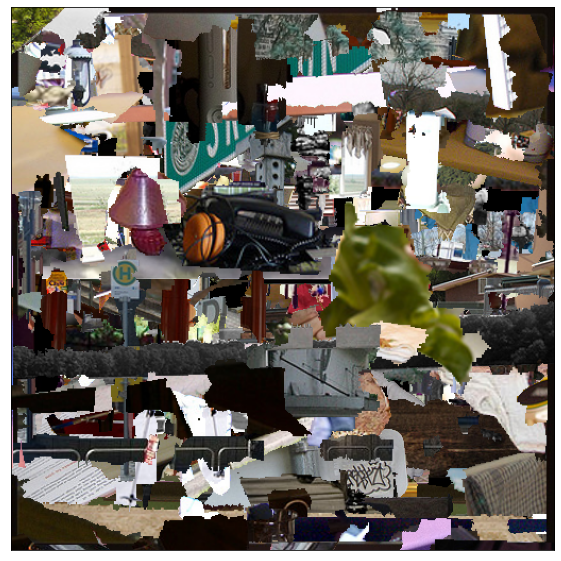

In [14]:
allowedCateg = all_category_names(exclude=['person', 'other'])
# allowedCateg = random.sample(allowedCateg, random.randint(1,len(allowedCateg)))
# allowedCateg = ["sky"]

blendConfig = {
  "use_blending" : False,
  "pyr_kernel_size" : 5,
  "pyr_kernel_sigma" : 1.,
  "mask_kernel_size" : 5,
  "mask_kernel_sigma" : 1.,
  "max_depth" : 5,
  "blur_masks" : True,
  "blur_iters" : 1,
  "plot_levels" : False
}


config = {
  # average size of each patch (1 being mean of distribution)
  'avgPatchSize' : 0.05,
  # average size variance of each patch added
  'avgPatchVariance' : 0.1,
  # minimum area of a patch added, expressed as percentage px after masking
  'minPatchArea' : 0.001, 
  # maximim area of a patch added, expressed as percentage px after masking
  'maxPatchArea' : 0.1, 
  # target percentage of pixels to fill
  'targetFill' : 0.99,
  # output image size
  'outputSize' : (512, 512),
  # prevent supercategories from appearing
  'allowedCategories' : allowedCateg,
  # choose either "stuff_ann" or "instance_ann"
  'ann_key' : "stuff_ann",
  # image blending options
  'image_blending' : blendConfig
}

image, metadata = botr.generate_image(config, imageProgress=False)
imshow(image)

In [19]:
_, description = generate_zipf_description(metadata, sentence_len=random.randint(3, 14))
name = generate_name(metadata["category_percentage"])
print(f'{name} : {description}')

0
1
2
3
4
5
6
7
furpwtsfg : Walkway front signs a it big couple half two tennis bike suit 


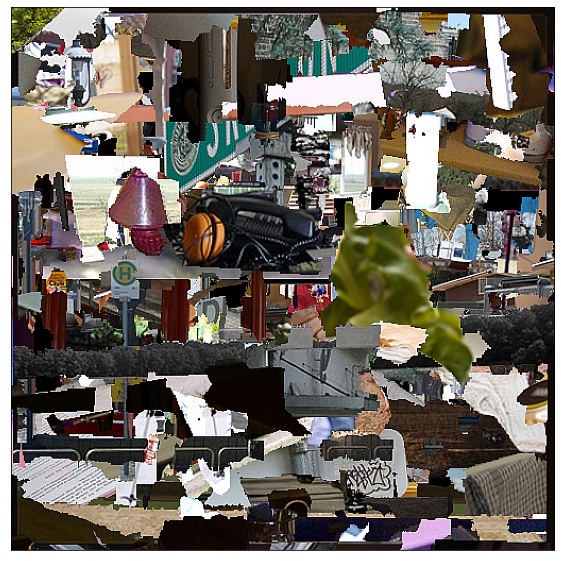

In [16]:
image = sharpen_image(image)
imshow(image)

In [17]:
metadata["name"] = name
metadata["description"] = description

In [18]:
print_pretty(metadata)

{
  "category_percentage": {
    "textile": 0.09157562255859375,
    "plant": 0.11656951904296875,
    "building": 0.021030426025390625,
    "furniture-stuff": 0.1831817626953125,
    "structural": 0.067108154296875,
    "raw-material": 0.133026123046875,
    "floor": 0.053073883056640625,
    "ceiling": 0,
    "sky": 0.042652130126953125,
    "ground": 0.048175811767578125,
    "water": 0.0277862548828125,
    "food-stuff": 0.046138763427734375,
    "solid": 0.00899505615234375,
    "wall": 0.10527420043945312,
    "window": 0.04583740234375,
    "other": 0,
    "person": 0,
    "vehicle": 0,
    "outdoor": 0,
    "animal": 0,
    "accessory": 0,
    "sports": 0,
    "kitchen": 0,
    "food": 0,
    "furniture": 0,
    "electronic": 0,
    "appliance": 0,
    "indoor": 0
  },
  "text_metadata": {
    "objects": [
      "floor",
      "wall",
      "textile",
      "textile",
      "building",
      "plant",
      "food-stuff",
      "furniture-stuff",
      "furniture-stuff",
      "p

In [9]:
image.save(f"generated/{name}.png")

In [2]:
import cv2
from pyramids import blend_masked_rgb, create_kernel
from utils import load_image_cv2, imshow, display_multiple_images
import numpy as np
from scipy.signal import convolve2d

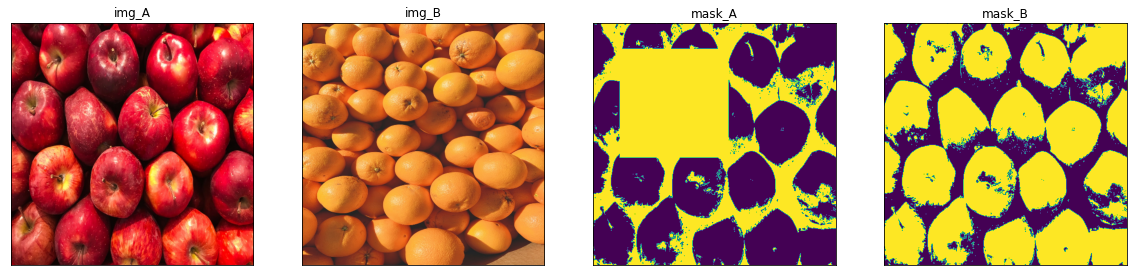

In [70]:
dims = (512, 512)
img_A = load_image_cv2("images/apple_image.jpeg")
img_B = load_image_cv2("images/orange_image.jpeg")

img_A = cv2.resize(img_A, dims)
img_B = cv2.resize(img_B, dims)

# imshow(img_A, size=(8,8))
# imshow(img_B, size=(8,8))

img_Gray = cv2.cvtColor(img_A, cv2.COLOR_RGB2GRAY)

mask_A = np.zeros((img_A.shape[0], img_A.shape[1], 1), dtype=float)
mask_A[img_Gray < 50] = 1

mask_B = (mask_A * -1) + 1


# mask_A[(mask_A.shape[0]//2)-200:(mask_A.shape[0]//2)+30,
#     (mask_A.shape[1]//2)-200:(mask_A.shape[1]//2)+30] = 1

# mask_B = (mask_A * -1) + 1


# imshow(mask_A, size=(8,8))
# imshow(mask_B, size=(8,8))

display_multiple_images([img_A, img_B, mask_A, mask_B],
['img_A', 'img_B', 'mask_A', 'mask_B'])

In [71]:
from pyramids import generate_pyramid, plot_pyramid_level, reconstruct

def dilate_mask(mask, kernel, iter=1):
  dilated = cv2.dilate(mask, kernel, iterations = iter)
  return dilated

def blur_mask(mask, kernel, steps=1):
  for _ in range(steps):
    mask = convolve2d(
      mask, kernel, mode='same', boundary='fill')
  mask = np.clip(mask, 0., 1.)
  mask = np.nan_to_num(mask)
  return mask

def blend_masked(
  img_A, img_B, mask_A, mask_B,
  blendConfig, plot_levels=False):

  pyrKernel = create_kernel(
    blendConfig['pyr_kernel_size'], blendConfig['pyr_kernel_sigma'])

  maskKernel = create_kernel(
    blendConfig['mask_kernel_size'], blendConfig['mask_kernel_sigma'])

  img1_G, img1_L = generate_pyramid(img_A, pyrKernel, blendConfig['max_depth'])
  _,      img2_L = generate_pyramid(img_B, pyrKernel, blendConfig['max_depth'])

  blended_L = []
  # reverse order of pyramid
  img1_L = img1_L[::-1]
  img2_L = img2_L[::-1]

  # iterate through levels and blend spatial frequencies
  for l_1, l_2 in zip(img1_L, img2_L):

    mask_A_scaled = cv2.resize(mask_A, (l_1.shape[0], l_1.shape[1]))
    mask_B_scaled = cv2.resize(mask_B, (l_2.shape[0], l_2.shape[1]))
    
    if blendConfig['blur_masks']:
      mask_A_scaled = blur_mask(mask_A_scaled, maskKernel, blendConfig['blur_iters'])
      mask_B_scaled = blur_mask(mask_B_scaled, maskKernel, blendConfig['blur_iters'])

    l_1 *= mask_A_scaled
    l_2 *= mask_B_scaled
    
    blend = l_1+l_2
    blended_L.append(blend)

    if plot_levels:
      display_multiple_images([l_1, l_2, mask_A_scaled, mask_B_scaled, blend],
                      ['l_1', 'l_2', 'mask_A', 'mask_B', 'blended'])
  blended_L = blended_L[::-1]
  recon = reconstruct(img1_G[-1], blended_L, pyrKernel)
  return recon

def normalize_values(values):
  values = (values - np.min(values)) / (np.max(values) - np.min(values))
  return values

# convert float 0.-1. to  uint8 0-255
def to_uint8_range(values):
  values = np.clip(values * 255, 0, 255)
  values = values.astype(np.uint8)
  return values

# convert uint8 0-255 to 0.-1.
def to_float_range(values):
  values = values.astype(float)
  values = np.clip(values / 255, 0., 1.)
  return values

def blend_masked_rgb(img_A, img_B, 
  mask_A, mask_B, blendConfig):

  img_A = to_float_range(img_A)
  img_B = to_float_range(img_B)

  blended_rgb = []
  for channel in range(3):
    plot_levels = False
    if channel==0:
      plot_levels=True
    blended = blend_masked(
        img_A[:,:,channel], img_B[:,:,channel], 
        mask_A, mask_B, blendConfig, 
        plot_levels=plot_levels)
          
    blended_rgb.append(blended)

  blended_rgb = np.stack(blended_rgb, axis=-1)
  blended_rgb = normalize_values(blended_rgb)
  blended_rgb = to_uint8_range(blended_rgb)
  
  return blended_rgb

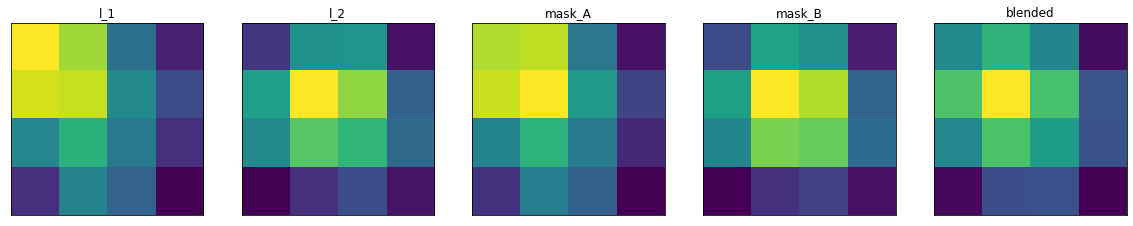

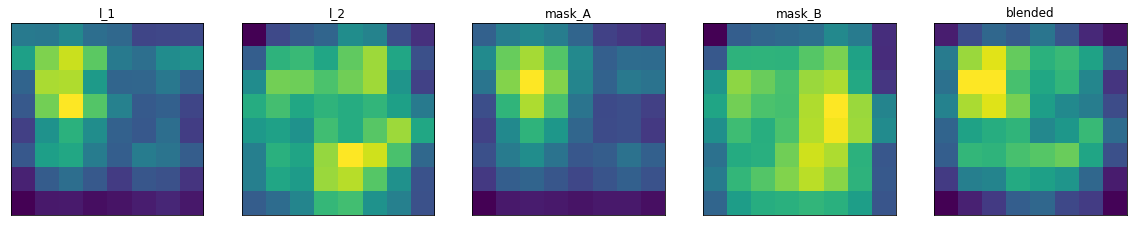

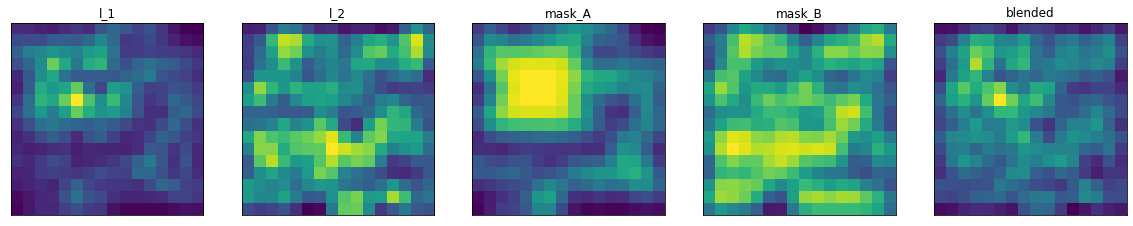

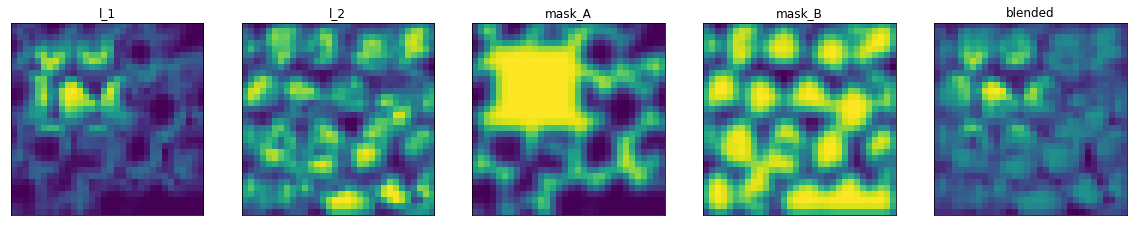

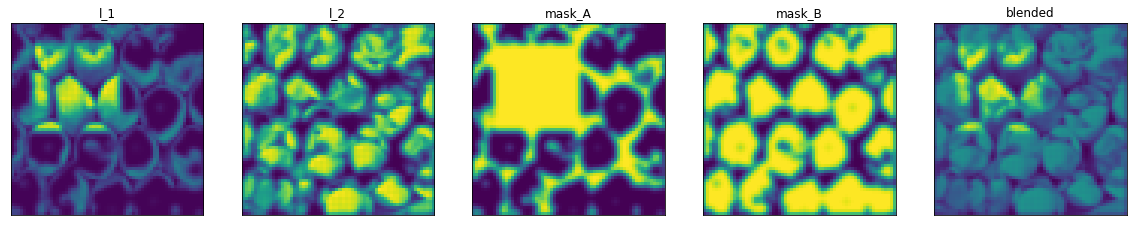

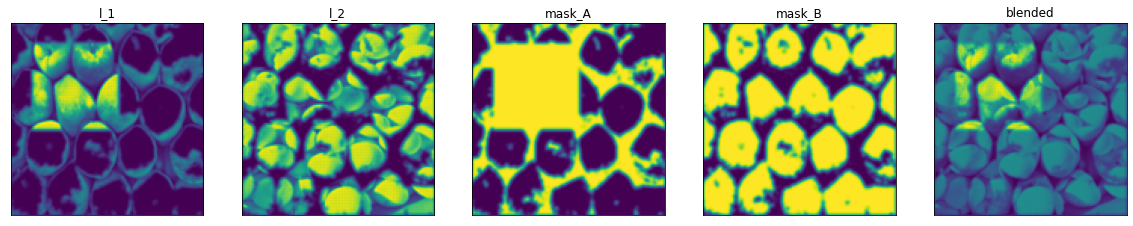

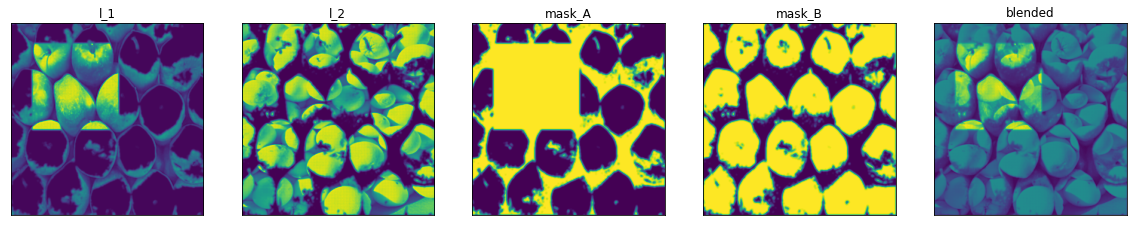

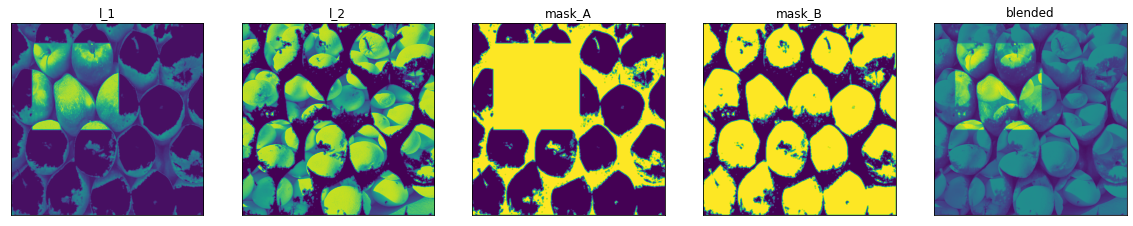

255


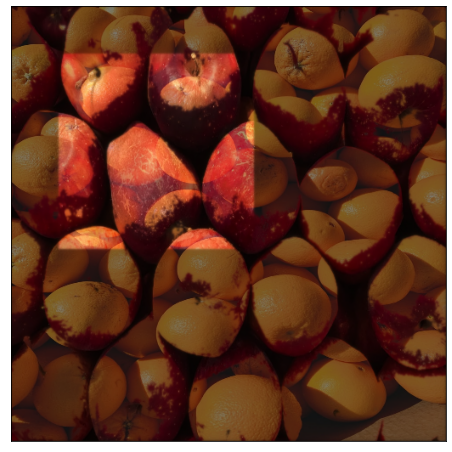

In [72]:
blendConfig = {
  "pyr_kernel_size" : 5,
  "pyr_kernel_sigma" : 1.,
  "mask_kernel_size" : 5,
  "mask_kernel_sigma" : 1.,
  "max_depth" : None,
  "blur_masks" : True,
  "blur_iters" : 1
}

blended = blend_masked_rgb(
    img_A=img_A,
    img_B=img_B,
    mask_A=mask_A,
    mask_B=mask_B,
    blendConfig=blendConfig
)

print(np.max(blended))
imshow(blended, size=(8,8))

In [67]:
img_A_masked = to_float_range(img_A) * mask_A
img_B_masked = to_float_range(img_B) * mask_B
normal_composite = img_A_masked + img_B_masked

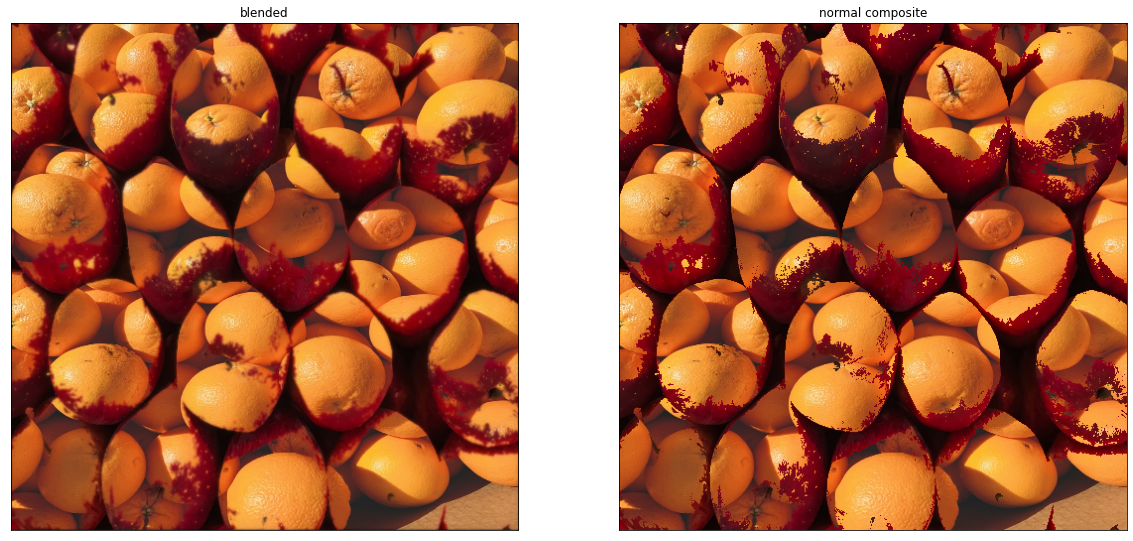

In [68]:
display_multiple_images([blended, normal_composite],["blended", "normal composite"])